<a href="https://colab.research.google.com/github/MyNameIsEldar/Road-Accident-Risk-Assessment/blob/main/Road_Accident_Risk_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

Этот проект сделан в рамках курса от Яндекс.

Поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

## Импоты библиотек

In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier

## Подключитесь к базе. Загрузите таблицы sql

### Конфигурация для подключения к базе данных

In [ ]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 


connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [ ]:
engine = create_engine(connection_string) 

## Проведите первичное исследование таблиц

Посмотрим на таблицы

In [ ]:
# query = '''
# SELECT *
# FROM vehicles;
# '''
# pd.read_sql_query(query, con=engine).head(10)

In [ ]:
# query = '''
# SELECT *
# FROM parties;
# '''
# pd.read_sql_query(query, con=engine).head(10)

In [ ]:
# query = '''
# SELECT *
# FROM collisions;
# '''
# pd.read_sql_query(query, con=engine).head(10)

Все необходимые таблицы существуют и в них есть колонка `case_id`, которая явлется внешним ключем для их связи.

##  Проведите статистический анализ факторов ДТП

### Анализ количества аварий по месяцам

Посмотрим, на какие месяца приходится больше всего аварий

In [ ]:
query = '''
SELECT EXTRACT(YEAR FROM collision_date) AS year,
       EXTRACT(MONTH FROM collision_date) AS month,
       COUNT(case_id) AS cases_count
FROM collisions
GROUP BY EXTRACT(YEAR FROM collision_date), EXTRACT(MONTH FROM collision_date)
'''

cases_by_months = pd.read_sql_query(query, con=engine)
cases_by_months

,year,month,cases_count
0,2009.0,1.0,35062
1,2009.0,2.0,34480
2,2009.0,3.0,36648
3,2009.0,4.0,35239
4,2009.0,5.0,36916
5,2009.0,6.0,34202
6,2009.0,7.0,35161
7,2009.0,8.0,34508
8,2009.0,9.0,35555
9,2009.0,10.0,37835


Построим график для более наглядной визуализации

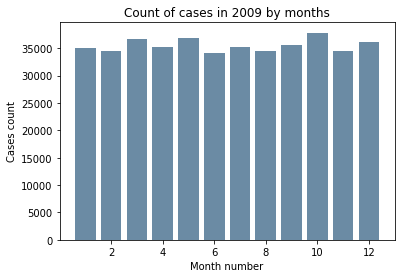

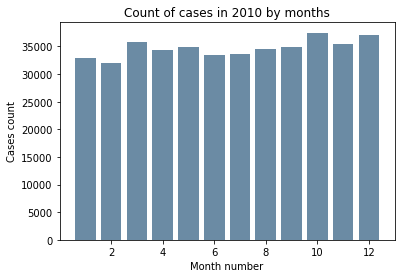

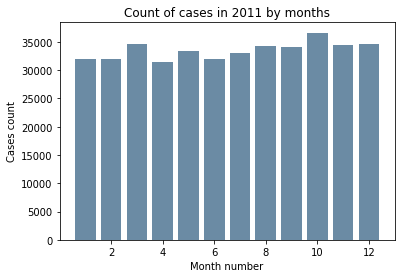

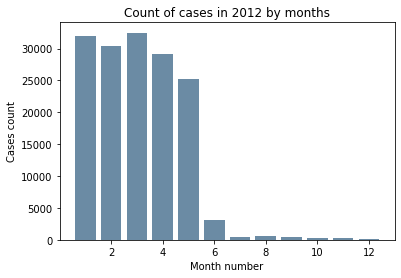

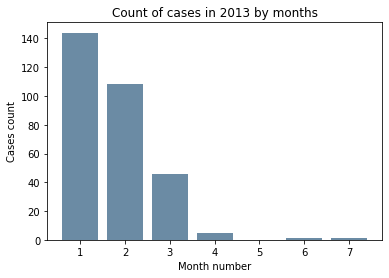

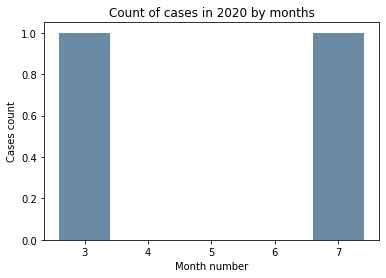

In [ ]:
for year in cases_by_months['year'].value_counts().sort_index().index:
    case = cases_by_months[cases_by_months['year'] == year]
    plt.bar(case['month'], case['cases_count'], color='xkcd:grey blue')
    plt.title(f'Count of cases in {int(year)} by months')
    plt.ylabel('Cases count')
    plt.xlabel('Month number')
    plt.show()

В период с 2009 по 2011 количество аварий по месяцам распределенно равномерно, в каких-то месяцах чуть больше, в каких-то чуть меньше. В 2012 году в первую половину года данные примерно такие же как и ранее, однако начиная со второй половины аварий будто не происходило, вероятно данных просто не хватает. В 2013 и 2020 годах тоже мало информации о дтп. 

### Задачи для коллег

Для того, чтобы все были знаком с данными подберем список из 6 задач по анализу таблиц

Список задач:

- Проанализируйте количество ДТП в зависимости от состояния погоды (`collisions`)
- Проведите анализ серьезности повреждений от возраста автомобиля (`collisions` и `vehicle`)
- Проведите анализ частоты происшествий в зависимости от трезвости участника ДТП (`collisions` и `parties`)
- Проведите анализ зависимости серьезности повреждений от физического состояния участника ДТП (`collisions` и `parties`)
- Выясните, в какой диапазон времени происходит наибольшее количество аварий (`collisions`)
- Определите, на какизх видах дорог набиолее верятно ДТП (`collisions`)

### Примеры решения задач

Порядок решения для двух задач будет идентичен:

- Напишите SQL запрос
- Проведите анализ и постройте график
- Сделайте вывод

Приведем пример решения двух задач:

1. Проведите анализ серьезности повреждений от возраста автомобиля (`collisions` и `vehicle`)

2. Проведите анализ зависимости серьезности повреждений от физического состояния участника ДТП (`collisions` и `parties`)

#### Задача 1

In [ ]:
query = '''
SELECT v.vehicle_age AS age,
       c.collision_damage AS damage
       
FROM collisions AS c
JOIN vehicles AS v ON c.case_id = v.case_id
WHERE v.vehicle_age IS NOT NULL 
        AND c.collision_damage IS NOT NULL
'''

age_damage = pd.read_sql_query(query, con=engine)
age_damage.head()

,age,damage
0,8,small damage
1,11,scratch
2,6,small damage
3,3,small damage
4,7,scratch


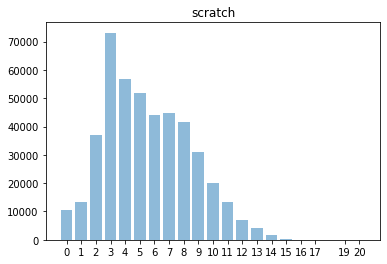

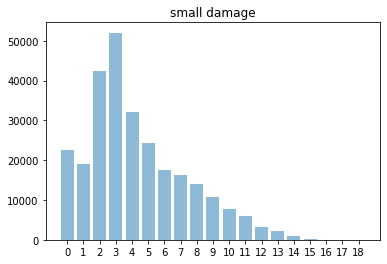

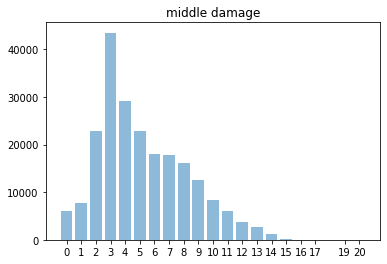

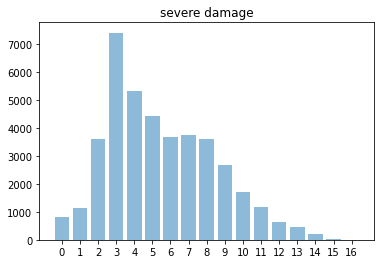

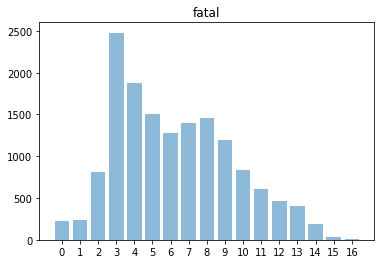

In [ ]:
damage_vals = ['scratch', 'small damage', 'middle damage', 'severe damage', 'fatal']

for value in damage_vals:
    # Группируем по году и считаем количество упоминаний, при этом добавляем условие на возраст, 
    # тк. в данных есть автос возрастом 160
    
    d = age_damage[(age_damage['damage'] == value) & (age_damage['age'] < 100)].groupby(['age']).count()
    plt.bar(d.index, d['damage'], alpha=.5)
    plt.xticks(list(d.index))
    plt.title(value)
    plt.show()

Лидерами по ДТП среди всех видов повреждений оказались авто с возрастом 2-4 года.

Почти на всех графиках видно, что пересекая рубеж в 3 года частота повреждений уменьшается.

В категории `small damage` новые авто появляются чаще, чем в остальных категориях.

#### Задача 2

In [ ]:
query = '''
WITH p AS(
SELECT * 
FROM parties
WHERE at_fault = 1
)

SELECT c.collision_damage,
        p.party_sobriety
FROM collisions AS c
JOIN p ON c.case_id = p.case_id
WHERE p.party_sobriety <> 'not applicable'
'''

sobriety_damage = pd.read_sql_query(query, con=engine)
sobriety_damage.head()

,collision_damage,party_sobriety
0,scratch,had not been drinking
1,fatal,had not been drinking
2,middle damage,impairment unknown
3,small damage,"had been drinking, under influence"
4,scratch,had not been drinking


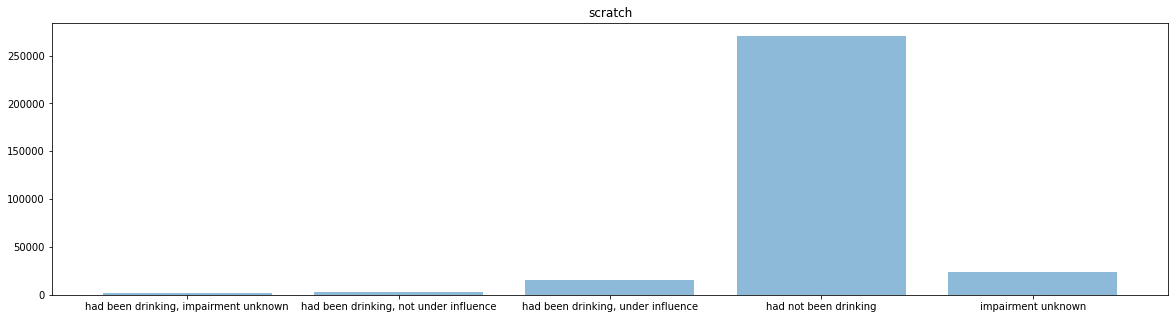

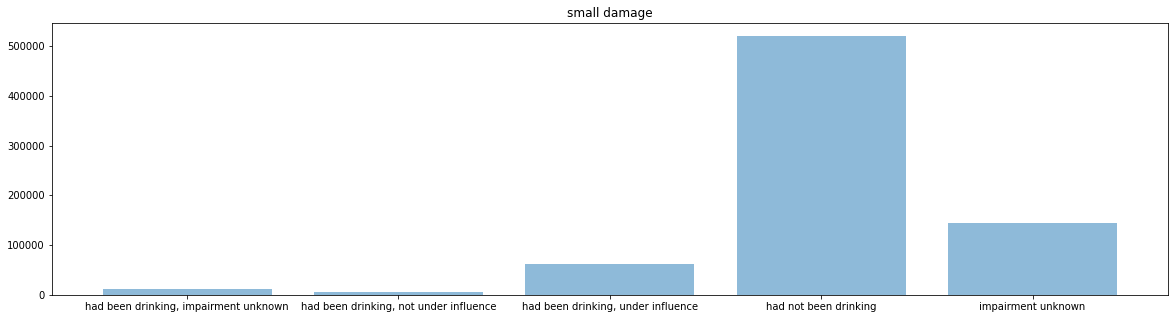

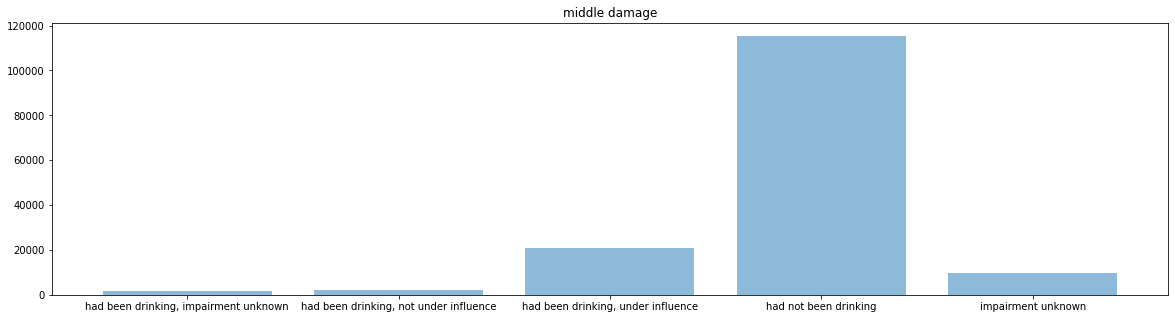

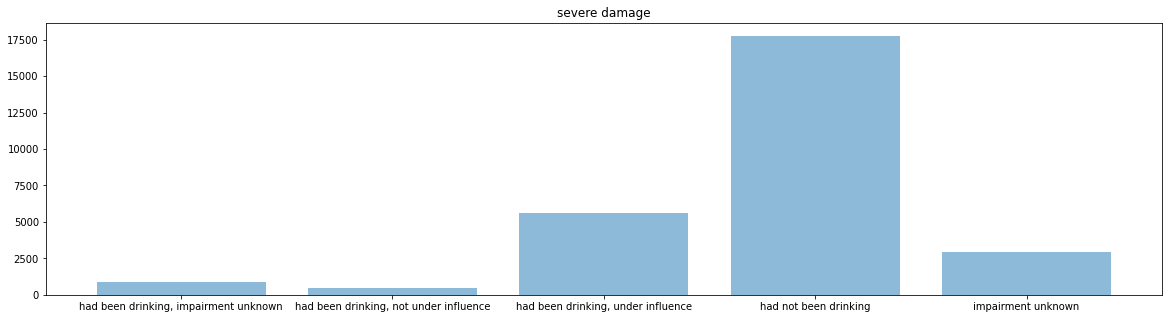

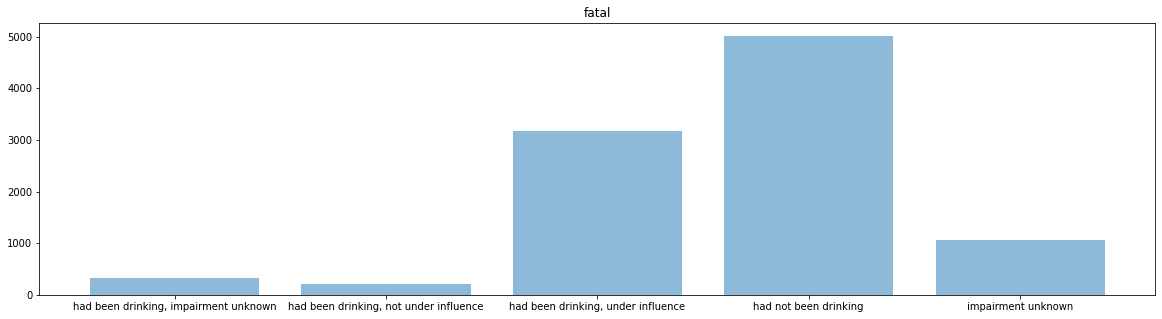

In [ ]:
for value in damage_vals:
    # Группируем по состоянию винвоного и считаем количество упоминаний
    d = sobriety_damage[(sobriety_damage['collision_damage'] == value)].groupby(['party_sobriety']).count()
    plt.figure(figsize=(20,5))
    plt.bar(d.index, d['collision_damage'], alpha=.5)
    plt.xticks()
    plt.title(value)
    plt.show()

В основном ДТП происходили по вине трезвых водителей.

Тем не менее видна закономерность: количество ДТП произошедших по вине пьяных водителей возрастает с тяжестью повреждений.
Аварии с фатальными повреждениями чаще совершаются водителями в нетрезвом состоянии в процентном соотношении, чем другие виды аварий

## Создайте модель для оценки водительского риска

### Подготовка данных

In [ ]:
query = '''
SELECT *
FROM parties AS p
INNER JOIN collisions AS c ON p.case_id = c.case_id
INNER JOIN vehicles AS v ON p.case_id = v.case_id
WHERE (p.party_type = 'car' OR at_fault = 0) 
        AND c.collision_damage <> 'scratch'
        AND EXTRACT(YEAR FROM c.collision_date) = 2012
'''
df = pd.read_sql_query(query, con=engine)
df.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,case_id,...,lighting,control_device,collision_date,collision_time,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,2670815,5607652,2,road bumper,0,NaN,None,None,NaN,5607652,...,dark with street lights,none,2012-04-25,20:11:00,1470493,5607652,1,sedan,auto,7.0
1,2313486,5403581,2,road signs,0,41.0,"had been drinking, impairment unknown",None,0.0,5403581,...,dark with street lights,none,2012-03-10,23:25:00,1275845,5403581,2,hatchback,manual,6.0
2,2406519,5454923,4,road signs,0,33.0,had not been drinking,None,0.0,5454923,...,dark with street lights,functioning,2012-01-12,21:40:00,1326547,5454923,5,hatchback,manual,4.0
3,2406519,5454923,4,road signs,0,33.0,had not been drinking,None,0.0,5454923,...,dark with street lights,functioning,2012-01-12,21:40:00,1326546,5454923,4,hatchback,manual,5.0
4,2406519,5454923,4,road signs,0,33.0,had not been drinking,None,0.0,5454923,...,dark with street lights,functioning,2012-01-12,21:40:00,1326544,5454923,2,coupe,manual,5.0


Проверим, какие виновники в датасете получились

In [ ]:
df[df['at_fault'] == 1]['party_type'].value_counts()

car    55616
Name: party_type, dtype: int64

In [ ]:
df[df['at_fault'] == 0]['party_type'].value_counts()

car            62795
road bumper     4245
road signs      2917
building        1578
other            387
Name: party_type, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127630 entries, 0 to 127629
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           127630 non-null  int64  
 1   case_id                      127630 non-null  object 
 2   party_number                 127630 non-null  int64  
 3   party_type                   127538 non-null  object 
 4   at_fault                     127630 non-null  int64  
 5   insurance_premium            117797 non-null  float64
 6   party_sobriety               124993 non-null  object 
 7   party_drug_physical          12810 non-null   object 
 8   cellphone_in_use             112813 non-null  float64
 9   case_id                      127630 non-null  object 
 10  county_city_location         127630 non-null  object 
 11  county_location              127630 non-null  object 
 12  distance                     127630 non-null  float64
 13 

## Проведите анализ важности факторов ДТП

### Выявление важных факторов

Начнем со столбцов дублирующих информацию, `country_city_location` содержит ту же информацию, что и `country_location`, но в другом виде. Избавимся от него

In [ ]:
df = df.drop(columns='county_city_location')

Избавимся от признаков, которые мы заранее не могли знать. Вероятно это отрицательно скажется на метрике, но очевидно лучше скажется на результате исследования.

In [ ]:
df = df.drop(columns=['party_count',
            'collision_damage',
            'primary_collision_factor',
            'pcf_violation_category',
            'type_of_collision',
            'motor_vehicle_involved_with'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127630 entries, 0 to 127629
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127630 non-null  int64  
 1   case_id               127630 non-null  object 
 2   party_number          127630 non-null  int64  
 3   party_type            127538 non-null  object 
 4   at_fault              127630 non-null  int64  
 5   insurance_premium     117797 non-null  float64
 6   party_sobriety        124993 non-null  object 
 7   party_drug_physical   12810 non-null   object 
 8   cellphone_in_use      112813 non-null  float64
 9   case_id               127630 non-null  object 
 10  county_location       127630 non-null  object 
 11  distance              127630 non-null  float64
 12  direction             96337 non-null   object 
 13  intersection          127175 non-null  float64
 14  weather_1             127168 non-null  object 
 15  

Так же можно избавиться от столбцов `insurance_premium`, `party_number`, `party_type`. Неинформативные признаки для нашей задачи.

`id` и `case_id` тоже неинформативны для задачи.

In [ ]:
df = df.drop(columns=['insurance_premium', 'id', 'case_id', 'party_number', 'party_type'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127630 entries, 0 to 127629
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   at_fault              127630 non-null  int64  
 1   party_sobriety        124993 non-null  object 
 2   party_drug_physical   12810 non-null   object 
 3   cellphone_in_use      112813 non-null  float64
 4   county_location       127630 non-null  object 
 5   distance              127630 non-null  float64
 6   direction             96337 non-null   object 
 7   intersection          127175 non-null  float64
 8   weather_1             127168 non-null  object 
 9   location_type         56339 non-null   object 
 10  road_surface          126733 non-null  object 
 11  road_condition_1      126952 non-null  object 
 12  lighting              127213 non-null  object 
 13  control_device        127124 non-null  object 
 14  collision_date        127630 non-null  object 
 15  

### Проведем исследовательский анализ

#### Численные признаки

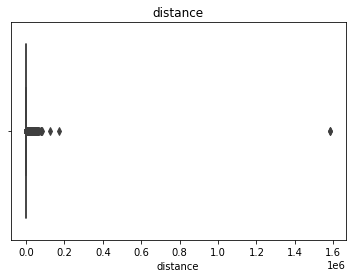

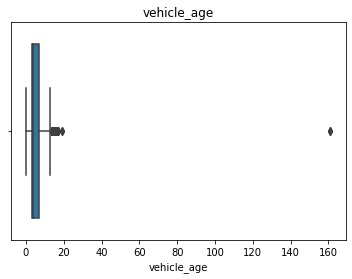

In [ ]:
num_cols = ['distance', 'vehicle_age']

for col in num_cols:
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()

Избавимся от аномальных значений в столбцах

count    1.240060e+05
mean     7.131054e+02
std      6.749931e+03
min      0.000000e+00
25%      3.000000e+00
50%      1.100000e+02
75%      5.280000e+02
max      1.584000e+06
Name: distance, dtype: float64


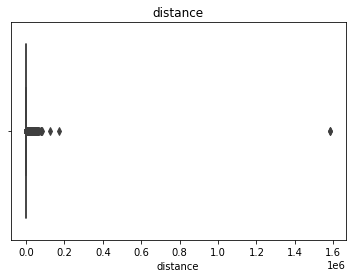

count    124006.000000
mean          4.918149
std           3.137469
min           0.000000
25%           3.000000
50%           4.000000
75%           7.000000
max          19.000000
Name: vehicle_age, dtype: float64


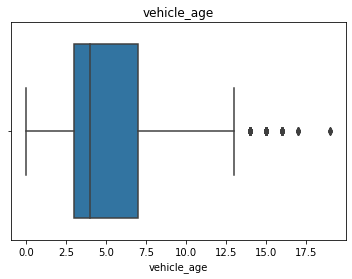

In [ ]:
df = df[df['vehicle_age'] < 100]

for col in num_cols:
    print(df[col].describe())
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()

Все равно остается достаточно много выбросов в столбце `distance`.
Есть смысл преобразовать данные в киломметры

In [ ]:
df['distance'] = df['distance'] // 1000

count    124006.000000
mean          0.515032
std           6.729387
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1584.000000
Name: distance, dtype: float64


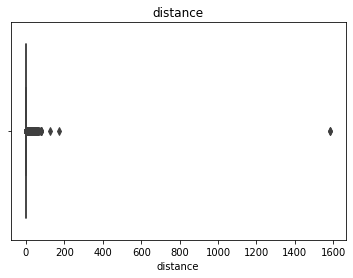

count    124006.000000
mean          4.918149
std           3.137469
min           0.000000
25%           3.000000
50%           4.000000
75%           7.000000
max          19.000000
Name: vehicle_age, dtype: float64


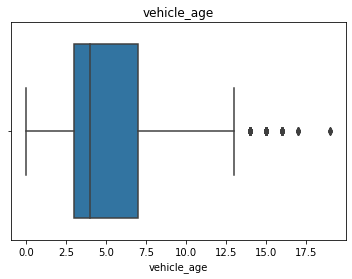

In [ ]:
for col in num_cols:
    print(df[col].describe())
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()

Так же избавимся от аномальных значений в столбце `distance` 

In [ ]:
df = df[df['distance'] < 200]

count    124004.000000
mean          0.489492
std           2.200767
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         171.000000
Name: distance, dtype: float64


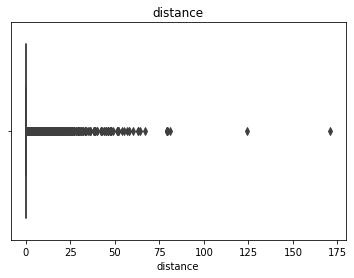

count    124004.000000
mean          4.918180
std           3.137485
min           0.000000
25%           3.000000
50%           4.000000
75%           7.000000
max          19.000000
Name: vehicle_age, dtype: float64


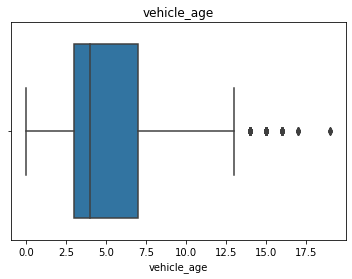

In [ ]:
for col in num_cols:
    print(df[col].describe())
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()

Попробуем классифицировать данные `distance`

In [ ]:
# разделим на 5 категорий по дистанции
# Выделил логичные категории дистанции
def cls_dist(x):
    if x <= 5:
        return 'A'
    if x <= 10:
        return 'B'
    if x <= 50:
        return 'C'
    return 'D'

In [ ]:
df['distance'] = df['distance'].apply(cls_dist)
df['distance'].head()

0    A
1    A
2    A
3    A
4    A
Name: distance, dtype: object

#### Категориальные признаки

Теперь посмотрим на категориальные признаки, построим для них графики распределения классов


AT_FAULT


0    69980
1    54024
Name: at_fault, dtype: int64

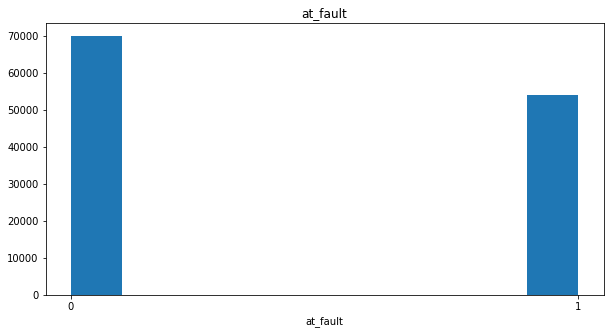


PARTY_SOBRIETY


had not been drinking                     103099
had been drinking, under influence          6514
impairment unknown                          6070
not applicable                              4157
had been drinking, not under influence      1015
Name: party_sobriety, dtype: int64

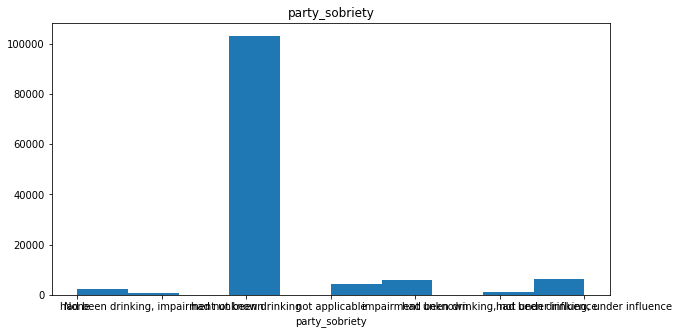


PARTY_DRUG_PHYSICAL


G                        6070
not applicable           4157
under drug influence     1390
sleepy/fatigued           523
impairment - physical     187
Name: party_drug_physical, dtype: int64

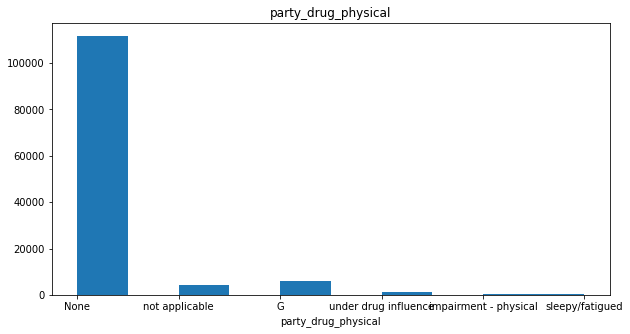


CELLPHONE_IN_USE


0.0    107657
1.0      2301
Name: cellphone_in_use, dtype: int64

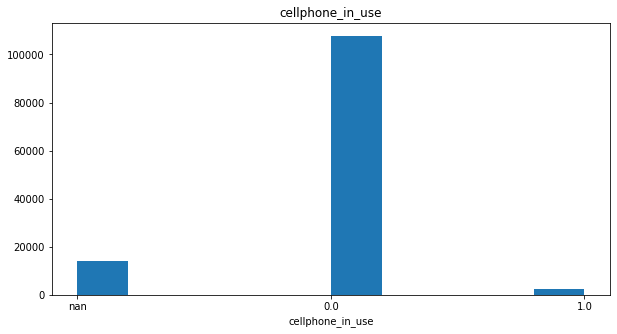


COUNTY_LOCATION


los angeles       38769
orange            12019
san diego          8258
san bernardino     7648
riverside          7077
Name: county_location, dtype: int64

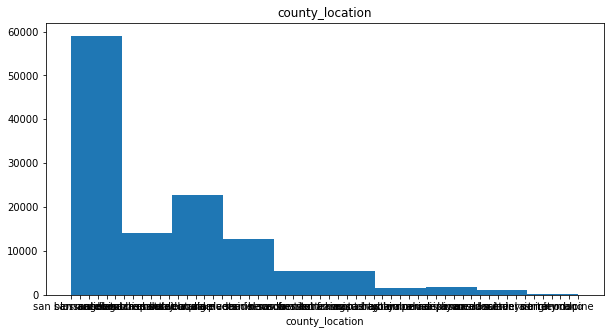


DISTANCE


A    121796
B      1319
C       860
D        29
Name: distance, dtype: int64

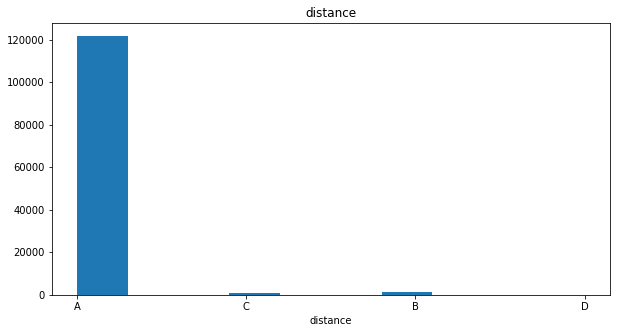


DIRECTION


north    26280
south    25845
west     21239
east     20561
Name: direction, dtype: int64

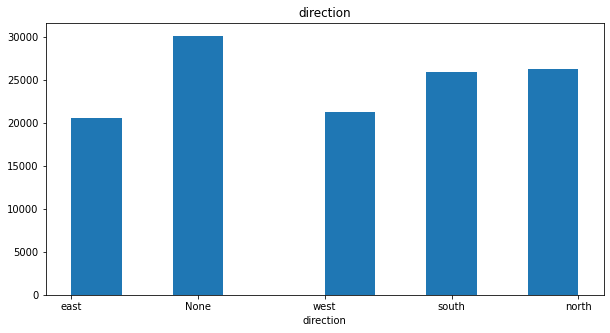


INTERSECTION


0.0    94904
1.0    28663
Name: intersection, dtype: int64

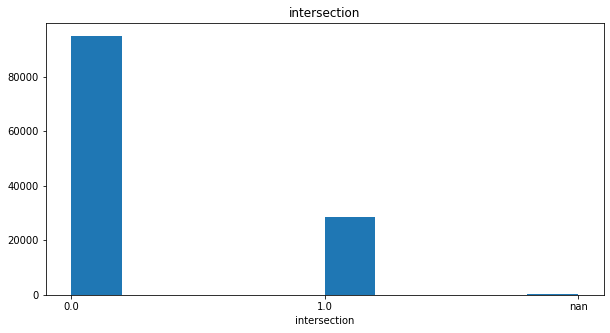


WEATHER_1


clear      100834
cloudy      17515
raining      4406
fog           420
snowing       284
Name: weather_1, dtype: int64

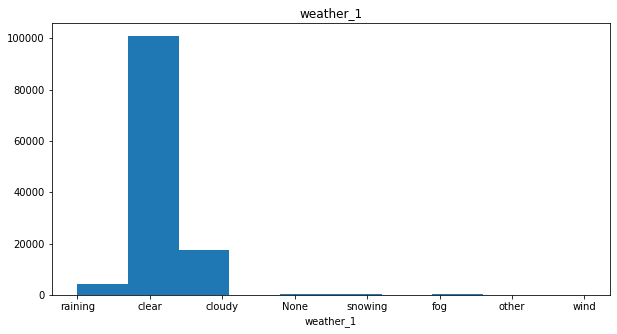


LOCATION_TYPE


highway         46251
ramp             6268
intersection     2903
Name: location_type, dtype: int64

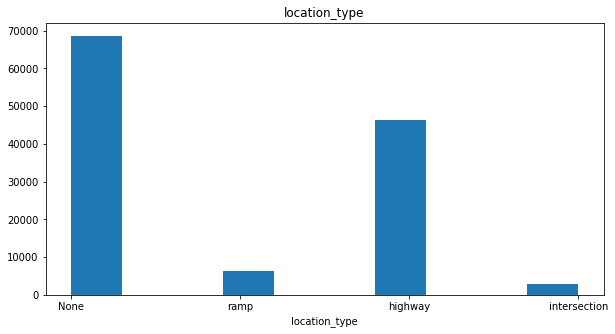


ROAD_SURFACE


dry         112031
wet          10425
snowy          621
slippery        77
Name: road_surface, dtype: int64

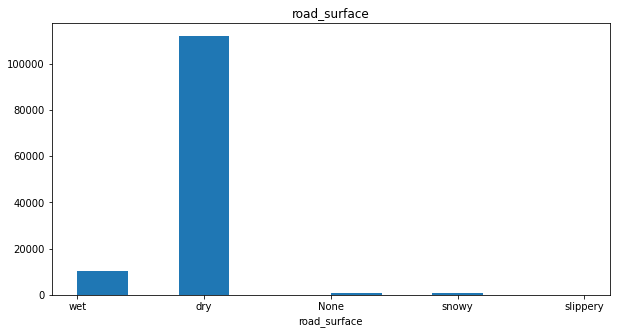


ROAD_CONDITION_1


normal          119143
construction      2332
obstruction        507
holes              492
other              462
Name: road_condition_1, dtype: int64

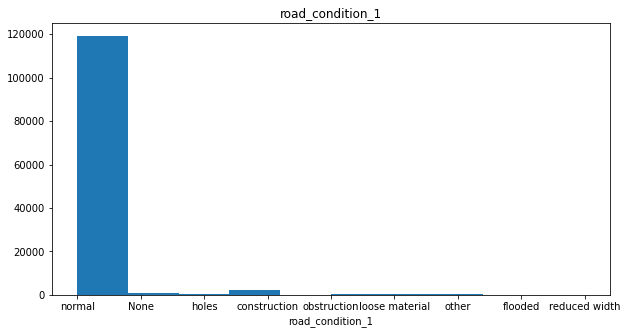


LIGHTING


daylight                                   85752
dark with street lights                    24149
dark with no street lights                  9494
dusk or dawn                                3884
dark with street lights not functioning      318
Name: lighting, dtype: int64

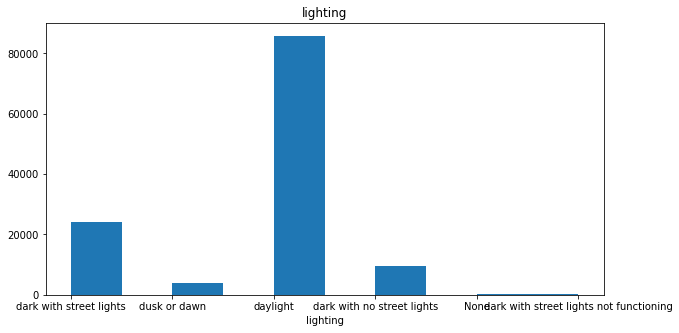


CONTROL_DEVICE


none               80831
functioning        42364
not functioning      250
obscured              74
Name: control_device, dtype: int64

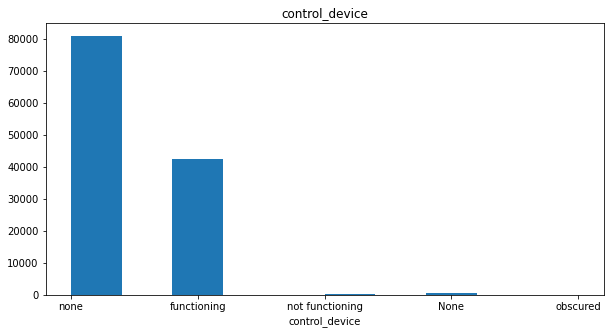


VEHICLE_TYPE


sedan        76316
coupe        37709
hatchback     5940
minivan       3924
other          115
Name: vehicle_type, dtype: int64

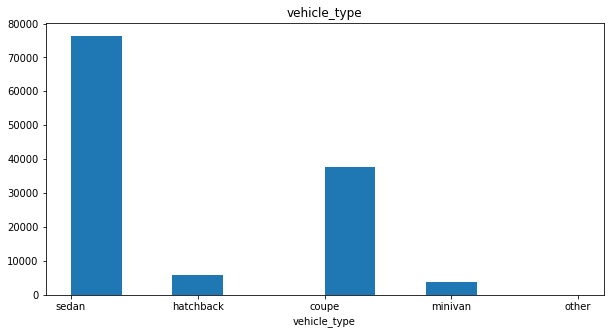


VEHICLE_TRANSMISSION


manual    64884
auto      57592
Name: vehicle_transmission, dtype: int64

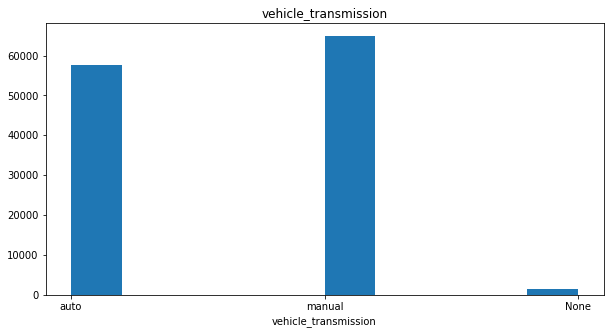


VEHICLE_AGE


3.0    23315
4.0    15706
2.0    13851
5.0    12627
6.0     9142
Name: vehicle_age, dtype: int64

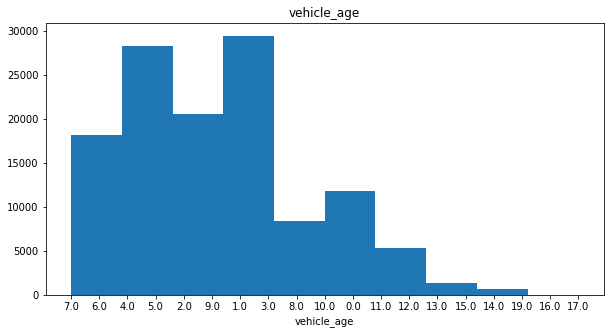

In [ ]:
cat_cls = df.columns.drop(['collision_date', 'collision_time'])

for col in cat_cls:
    print()
    print(f'{col}'.upper())
    display(df[col].value_counts().head())
    plt.figure(figsize=(10,5))
    plt.title(col)
    plt.xlabel(col)
    plt.hist(df[col].apply(str))
    plt.show()

Во-первых, видно, что классы целевого признака сбалансированы, это хорошая новость для нас, не нужно будет дополнительно обрабатываать данные. 

В данных присутствует достаточно больше количество пропусков, при том обрабатывать их тоже нужно по разному.

С датами и временем отдельно будет проведена работа, разобьем даты на месяца и дни, а время категоризируем по частям дня (утро, день, вечер, ночь).

## Предобработка данных

Для начала избавимся от дубликатов

In [ ]:
df = df.drop_duplicates()


Обработаем пропуски

Обработка будет зависеть от характера данных, где-то приведем к наиболее частому значению, где-то добавим специальный класс, чтобы однозначно описать пропуски (например в столбце `location_type`)

In [ ]:
df['party_drug_physical'] = df['party_drug_physical'].replace('G', 'Unkown').fillna('Unkown')

Обработали так же значения `G`, для более ясной трактовки

In [ ]:
df['party_drug_physical'].value_counts()

Unkown                   101948
not applicable             3120
under drug influence       1373
sleepy/fatigued             518
impairment - physical       187
Name: party_drug_physical, dtype: int64

In [ ]:
df['cellphone_in_use'] = df['cellphone_in_use'].fillna(0)

df['cellphone_in_use'].value_counts()

0.0    105157
1.0      1989
Name: cellphone_in_use, dtype: int64

In [ ]:
df['county_location'].isna().sum()

0

Здесь все ок, обрабатывать нечего

In [ ]:
df['direction'] = df['direction'].fillna('Unkown')
df['direction'].value_counts()

Unkown    26741
north     22397
south     21902
west      18252
east      17854
Name: direction, dtype: int64

In [ ]:
df['intersection'] = df['intersection'].fillna(0)
df['intersection'].isna().sum()

0

In [ ]:
df['weather_1'] = df['weather_1'].fillna('clear')
df['weather_1'].value_counts()

clear      87387
cloudy     15229
raining     3850
fog          346
snowing      254
other         56
wind          24
Name: weather_1, dtype: int64

In [ ]:
df['location_type'] = df['location_type'].fillna('normal_road')
df['location_type'].value_counts()

normal_road     60713
highway         38233
ramp             5590
intersection     2610
Name: location_type, dtype: int64

In [ ]:
df['road_surface'] = df['road_surface'].fillna('dry')
df['road_condition_1'] = df['road_condition_1'].fillna('normal')
df['control_device'] = df['control_device'].fillna('none')
df['vehicle_transmission'] = df['vehicle_transmission'].fillna('Unkown')
df['lighting'] = df['lighting'].fillna('daylight')
df['party_sobriety'] = df['party_sobriety'].fillna('had not been drinking')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107146 entries, 0 to 127629
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   at_fault              107146 non-null  int64  
 1   party_sobriety        107146 non-null  object 
 2   party_drug_physical   107146 non-null  object 
 3   cellphone_in_use      107146 non-null  float64
 4   county_location       107146 non-null  object 
 5   distance              107146 non-null  object 
 6   direction             107146 non-null  object 
 7   intersection          107146 non-null  float64
 8   weather_1             107146 non-null  object 
 9   location_type         107146 non-null  object 
 10  road_surface          107146 non-null  object 
 11  road_condition_1      107146 non-null  object 
 12  lighting              107146 non-null  object 
 13  control_device        107146 non-null  object 
 14  collision_date        107146 non-null  object 
 15  

Рассмотрим признаки времени.
Разобьем даты по дням и месяцам, создадим новые признаки. Время поделим на части дня (утро, день, вечер, ночь)

Но для начала избавимся от пропусков в столбце со временем.

In [ ]:
df['collision_time'].isna().sum() / len(df) * 100

0.12226308028297837

Около 1% пропусков, можно удалить строки с пропусками, не переживая за значительное уменьшение данных.

In [ ]:
df = df.dropna(subset=['collision_time']).reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107015 entries, 0 to 107014
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   at_fault              107015 non-null  int64  
 1   party_sobriety        107015 non-null  object 
 2   party_drug_physical   107015 non-null  object 
 3   cellphone_in_use      107015 non-null  float64
 4   county_location       107015 non-null  object 
 5   distance              107015 non-null  object 
 6   direction             107015 non-null  object 
 7   intersection          107015 non-null  float64
 8   weather_1             107015 non-null  object 
 9   location_type         107015 non-null  object 
 10  road_surface          107015 non-null  object 
 11  road_condition_1      107015 non-null  object 
 12  lighting              107015 non-null  object 
 13  control_device        107015 non-null  object 
 14  collision_date        107015 non-null  object 
 15  

In [ ]:
df['collision_date'] = pd.to_datetime(df['collision_date'])
df['collision_month'] = df['collision_date'].dt.month
df['collision_day'] = df['collision_date'].dt.day
df[['collision_date', 'collision_month', 'collision_day']].head()

,collision_date,collision_month,collision_day
0,2012-04-25,4,25
1,2012-03-10,3,10
2,2012-01-12,1,12
3,2012-01-12,1,12
4,2012-01-12,1,12


Разделим время

In [ ]:
df['collision_time'].head()

0    20:11:00
1    23:25:00
2    21:40:00
3    21:40:00
4    21:40:00
Name: collision_time, dtype: object

In [ ]:
df['collision_time']

0         20:11:00
1         23:25:00
2         21:40:00
3         21:40:00
4         21:40:00
            ...   
107010    11:20:00
107011    11:20:00
107012    17:30:00
107013    17:30:00
107014    21:39:00
Name: collision_time, Length: 107015, dtype: object

In [ ]:
def time_to_part(x):
    x = int(str(x).split(':')[0])
    if 4 <= x <= 10:
        return 'morning'
    if 11 <= x <= 16:
        return 'day'
    if 17 <= x <= 22:
        return 'evening'
    if x == 23 or (0 <= x <= 3):
        return 'night'

In [ ]:
df['collision_day_part'] = df['collision_time'].apply(lambda x: time_to_part(x))
df[['collision_day_part', 'collision_time']].head()

,collision_day_part,collision_time
0,evening,20:11:00
1,night,23:25:00
2,evening,21:40:00
3,evening,21:40:00
4,evening,21:40:00


Теперь удалим `collision_time` `collision_date`

In [ ]:
df = df.drop(columns=['collision_time', 'collision_date'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107015 entries, 0 to 107014
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   at_fault              107015 non-null  int64  
 1   party_sobriety        107015 non-null  object 
 2   party_drug_physical   107015 non-null  object 
 3   cellphone_in_use      107015 non-null  float64
 4   county_location       107015 non-null  object 
 5   distance              107015 non-null  object 
 6   direction             107015 non-null  object 
 7   intersection          107015 non-null  float64
 8   weather_1             107015 non-null  object 
 9   location_type         107015 non-null  object 
 10  road_surface          107015 non-null  object 
 11  road_condition_1      107015 non-null  object 
 12  lighting              107015 non-null  object 
 13  control_device        107015 non-null  object 
 14  vehicle_type          107015 non-null  object 
 15  

In [ ]:
df.head(10)

,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,county_location,distance,direction,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,vehicle_type,vehicle_transmission,vehicle_age,collision_month,collision_day,collision_day_part
0,0,had not been drinking,Unkown,0.0,san bernardino,A,east,0.0,raining,normal_road,wet,normal,dark with street lights,none,sedan,auto,7.0,4,25,evening
1,0,"had been drinking, impairment unknown",Unkown,0.0,san mateo,A,Unkown,1.0,clear,normal_road,dry,normal,dark with street lights,none,hatchback,manual,6.0,3,10,night
2,0,had not been drinking,Unkown,0.0,los angeles,A,west,0.0,clear,normal_road,dry,normal,dark with street lights,functioning,hatchback,manual,4.0,1,12,evening
3,0,had not been drinking,Unkown,0.0,los angeles,A,west,0.0,clear,normal_road,dry,normal,dark with street lights,functioning,hatchback,manual,5.0,1,12,evening
4,0,had not been drinking,Unkown,0.0,los angeles,A,west,0.0,clear,normal_road,dry,normal,dark with street lights,functioning,coupe,manual,5.0,1,12,evening
5,0,not applicable,not applicable,0.0,los angeles,A,west,0.0,clear,normal_road,dry,normal,dark with street lights,functioning,hatchback,manual,4.0,1,12,evening
6,0,not applicable,not applicable,0.0,los angeles,A,west,0.0,clear,normal_road,dry,normal,dark with street lights,functioning,hatchback,manual,5.0,1,12,evening
7,0,not applicable,not applicable,0.0,los angeles,A,west,0.0,clear,normal_road,dry,normal,dark with street lights,functioning,coupe,manual,5.0,1,12,evening
8,1,had not been drinking,Unkown,0.0,los angeles,A,east,0.0,clear,normal_road,dry,normal,dusk or dawn,functioning,sedan,auto,2.0,1,5,evening
9,0,had not been drinking,Unkown,0.0,san diego,A,Unkown,1.0,clear,normal_road,dry,normal,daylight,none,hatchback,auto,4.0,1,27,morning


### Разобьем на выборки

In [ ]:
target = df['at_fault']
features = df.drop(columns='at_fault')

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3, random_state=123)

print([x.shape for x in [X_train, y_train, X_test, y_test]])

[(74910, 19), (74910,), (32105, 19), (32105,)]


### Нормализуем и  кодируем данные

Сделаем кодировку категориальных признаков при помощи OHE

Сделаем нормализацию количественных данных, это столбец `vehicle_age`

In [ ]:
# std = StandardScaler()
# col = 'vehicle_age'

# X_train_num = std.fit_transform(X_train[col].values.reshape(-1, 1))
# X_test_num = std.transform(X_test[col].values.reshape(-1, 1))

# X_train_num

In [ ]:
numeric = ['vehicle_age']
categorical = X_train.columns.drop('vehicle_age')
col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numeric),
                            ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
                                remainder="passthrough"
                                  )

X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
print(X_train.shape)
print(X_train)
print(y_train)

(74910, 152)
[[ 0.0295047   0.          0.         ...  0.          0.
   0.        ]
 [-0.60909601  0.          1.         ...  0.          0.
   1.        ]
 [-0.92839636  0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 1.30670611  0.          0.         ...  0.          1.
   0.        ]
 [ 1.30670611  0.          0.         ...  0.          1.
   0.        ]
 [-0.60909601  0.          0.         ...  0.          0.
   0.        ]]
77986    0
20107    1
33452    0
29424    1
35346    1
        ..
63206    1
61404    0
17730    0
28030    1
15725    0
Name: at_fault, Length: 74910, dtype: int64


In [ ]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
print(y_train.shape, y_train)

(74910,) [0 1 0 ... 0 1 0]


In [ ]:
# y_train = y_train.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)

# print(y_train.shape, y_train)

#### Вывод по обработке

Провели предобработку признаков. 

Избавились от пропусков. 

Категоризовали некоторые признаки, такие как дата и время.

Стандартизировали данные, для кодирования пользовались техникой `OHE`, так же воспользовались `StandartScaler` для обработки численного признака.

### Построение моделей

Для решения задачи возьмем 3 модели: логистическую регрессию `LogisticRegression`, модель градиентного бустинга `CatBoost`, случайный лес `RandomForest`.

Будем идти по порядку, для каждой из моделей подберем оптимальные параметры и посмотрим на результат на валидационной выборке.

Для оценки качества модели будем использовать метрику `F1`, тк. в рамкахпоставленной задачи нам важны как точность, так и полнота.

#### Базовая модель

Для начала посмотрим, какую метрику покажет константная модель, предсказывающая для любых признаков 1

In [ ]:
constant_model = np.ones(y_train.shape)
constant_model_test = np.ones(y_test.shape)
constant_model.shape

(74910,)

In [ ]:
f1_score(y_train, constant_model)

0.6641820321694782

In [ ]:
f1_score(y_test, constant_model_test)

0.6657939575281553

#### Логистическая регрессия

In [ ]:
warnings.filterwarnings("ignore")

lr = LogisticRegression(max_iter=100)

lr.fit(X_train, y_train)

lr_f1 = cross_val_score(lr, X_train, y_train, cv=5, scoring='f1').mean()
print(lr_f1)

# lr_pred = lr.predict(X_test)
# f1_score(y_test, lr_pred)

KeyboardInterrupt: 

Подберем гиперпараметры для модели

In [ ]:
%%time

warnings.filterwarnings("ignore")


lr_grid = {'max_iter': [500],
           'penalty': ['l2'],
           'C': [.3, .6, 1]}

cv_lr = GridSearchCV(estimator=LogisticRegression(), param_grid=lr_grid, scoring='f1', cv=3)

cv_lr.fit(X_train, y_train)

In [ ]:
pd.DataFrame(cv_lr.cv_results_).sort_values('rank_test_score')[['rank_test_score', 'params', 'mean_test_score']]

In [ ]:
# Пободрали оптимальные параметры, посмотрим как покажет себя модель на тестовой подвыборке

In [ ]:
lr_best = LogisticRegression(C=.3, max_iter=500, penalty='l2')

lr_best.fit(X_train, y_train)
lr_pred = lr_best.predict(X_test) # пригодится для последующей проверки качества на тестовой выборке

Глобально метрика не изменилась, да и результаты модели не сильно показательные, посмотрим, как справятся остальные

#### CatBoost

In [ ]:
ctb_model = CatBoostClassifier(learning_rate=.01,
                               iterations=500,
                               depth=6,
                               eval_metric='F1',
                               l2_leaf_reg= 3.5)

In [ ]:
train = Pool(X_train, y_train)

ctb_model.fit(train, plot=True)


In [ ]:
cross_val_score(ctb_model, X_train, y_train, cv=5, scoring='f1').mean()

Подберем гиперпараметры для модели

In [ ]:
%%time

cat = CatBoostClassifier(eval_metric='F1')

grid = {'learning_rate': [0.03, 0.1],
        'depth': [6, 10],
        'l2_leaf_reg': [5, 9]}

grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, plot=True)

In [ ]:
best_params_cat = grid_search_result['params']

print(best_params_cat)

In [ ]:
grid_search_result['cv_results'].keys()

In [ ]:
ctb_f1 = max(grid_search_result['cv_results']['test-F1-mean'])
ctb_f1

Модель показала не самый лучший результат

Проверим следующую модель

In [ ]:
rfc = RandomForestClassifier(random_state=213)

In [ ]:
rfc.fit(X_train, y_train)

rfc_f1 = cross_val_score(rfc, X_train, y_train, cv=5, scoring='f1').mean()
print(rfc_f1)

Подберем параметры модели

In [ ]:
%%time

params = {'n_estimators': [50, 100],
         'max_depth': [None, 10]}

cv_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, scoring='f1')
cv_forest.fit(X_train, y_train)

In [ ]:
cv_info = pd.DataFrame(cv_forest.cv_results_).sort_values('rank_test_score')[['rank_test_score', 'params', 'mean_test_score']]
cv_info

In [ ]:
cv_forest.best_params_

In [ ]:
rfc_f1 = cv_info['mean_test_score'].max()
rfc_f1

#### Микровывод

Соберем результаты работы моделей при кросс-валидации в одну таблицу

In [ ]:
data = {'model': ['log_reg', 'grad_boost', 'random_forest'],
        'f1_score_cross_val': [lr_f1, ctb_f1, rfc_f1]}

models_results = pd.DataFrame(data)
models_results

Лучше всех (но все равно не достаточно хорошо) себя показал алгоритм логистической регрессии. 

Далее анализ и вывод будем строить именно по этой модели

Результат выбранной модели на тестовой выборке

In [ ]:
f1_score(y_test, lr_pred)

## Выводы

### Анализ модели

Проанализируем матрицу ошибок


In [ ]:
conf_m = confusion_matrix(y_test, lr_pred)

In [ ]:
plt.figure(figsize = (10,8))
plt.text(0, -0.13, f'Precision: {round(precision_score(y_test, lr_pred), 3)}', fontsize=14)
plt.text(0.6, -0.13, f'Recall: {round(recall_score(y_test, lr_pred), 3)}', fontsize=14)

classes = ["True Negative","False Positive","False Negative","True Positive"]

values = ["{0:0.0f}".format(x) for x in conf_m.flatten()]

percentages = ["{0:.1%}".format(x) for x in conf_m.flatten()/np.sum(conf_m)]

combined = [f"{i}\n{j}\n{k}" for i, j, k in zip(classes, values, percentages)]
combined = np.asarray(combined).reshape(2,2)

b = sns.heatmap(conf_m, annot=combined, fmt='', cmap='YlGnBu')

b.set(title='Confusion Matrix')

b.set(xlabel='Predicted', ylabel='Actual')

Из построенной матрицы ошибок видно, что модель лучше предсказывает `0` класс, не часто ошибается, предсказвая его.
Тем не менее с полложительным классом она справляется не очень хорошо.

Соответственно точность модели явно лучше полноты

Посмотрим на наиболее влиятельные признаки, которые выделила модель

In [ ]:
df.columns

In [ ]:
lr_coefs = lr_best.coef_
best_coefs = np.argsort(lr_coefs)[:, :5][0]
print(best_coefs)

df_dum = pd.get_dummies(df.drop('at_fault', axis=1), drop_first=True, columns=df.drop('at_fault', axis=1).columns.drop(['vehicle_age']))
most_imp_features = list(df_dum[df_dum.columns[best_coefs]].columns)

most_imp_features

Как видно, в наиболее важные для модели признаки попали фичи, описывающие плохое состояние водителя и определеное место.

Если с первыми тремя все очевидно, то с локацией не все так однозначно.

Исследуем зависимость целевой переменной от `party_sobriety_impairment unknown`

In [ ]:
loc_modoc = df[df['county_location'] == 'modoc']

plt.hist(loc_modoc['at_fault'])
plt.title('Зависимость количества ДТП\n в локации modoc')
plt.grid()
plt.show()

In [ ]:
perc = round(loc_modoc[loc_modoc['at_fault'] == 1]['at_fault'].count() / len(loc_modoc), 2)
print(f'Дтп в {perc * 100}% случаев')

Из графика видно, что в месте под название `modoc`, аварии менее вероятны. По всей видимости это маленький городок, судя по количетву случаев. Для того, чтобы убедиться в этом построим аналогичную столбчатую диаграмму для других городов.

In [ ]:
loc_la = df[df['county_location'] == 'los angeles']

plt.hist(loc_la['at_fault'])
plt.title('Зависимость количества ДТП\n в локации los angeles')
plt.grid()
plt.show()

loc_orange = df[df['county_location'] == 'orange']

plt.hist(loc_orange['at_fault'])
plt.title('Зависимость количества ДТП\n в локации orange')
plt.grid()
plt.show()

На этих графиках уже видно, что и дтп больше, и баланс классов более ровный, нельзя однозначно сказать, что тот или иной класс преобладает

Формально, для того, чтобы получить информацию о городе, в котором был взят автомобил достаточно иметь GPS трекер не нем. Насколько мне известно, сейчас все каршеринги и так оборудованы какими-либо системами отслеживания геопозиции. Поэтому для решения задачи определения местоположения нет необходимость дополнительно оснащать автомобиль.

### Общий вывод

В ходе работы над проектом выявили модель, которая показывает наилучшую метрику F1 как на тренировочном наборе данных, так и на тестовом.

Ей оказалась `логистическая регрессия` с гиперпараметрами C = 0.3, max_iter = 500, penalty = l2.

Однако модель нельзя назвать хорошей. Значение метрики, которе она показала, оказалось хуже, чем то, что показывает константная модель. Исходя из этого можно сделать вывод, что предсказания такой модели не достаточно хороши, чтобы ее использовать. 

С теми данными, которые сейчас имеются создать адекватную систему оценки вероятности ДТП пока не удалось. Я считаю, что для более достойной работы модели необходимо больше данных о водителе.

Например, такие факторы как стаж (не зря в страховых компаниях этот фактор явлется одним из основных), история использования каршеринга, формальный критерий, описывающий безопасность вождения (на сколько средняя скорость водителя отличается от средней скорости потока, можно сделать на основе данных использоания того же каршеринга или навигатора) и многие другие факторы могут помочь в улучшении работы моделей.